## Risk factor of cigarette smoking
#### insights from healthcare dataset analysis 

The analysis we are conducting aims to examine the risk factors caused by smoking cigarettes by analyzing a healthcare dataset. Specifically, this analysis seeks to investigate the correlation between age, blood glucose levels, smoking status, and the incidence of heart diseases. By examining these variables, we hope to identify patterns and potential risk factors associated with them.

Authors:
* Giuseppe Lentini
* Sara Di Vincenzo

In [1]:
#import section
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
# loading the dataset
path = 'healthcare-dataset-stroke-data.csv'
initial_df = pd.read_csv(path)

# we'll work on a copy of the initial DataFrame as a best practice
df = initial_df.copy()

### 2 - Data preprocessing
Data preprocessing is a crucial step in dataset analysis. Raw data often contains errors, missing values, outliers, and inconsistencies that can distort results. Preprocessing ensures data quality and consistency by cleaning and standardizing it, making it suitable for analysis.


In [3]:
# 2.1 -fill missing bmi column with median value
df['bmi'] = df['bmi'].fillna(df['bmi'].median())
 

# 2.2 - remove unnecessary columns
cols_to_utilize = df.columns.difference(['id', 'ever_married'])
df = df[cols_to_utilize]

# 2.3 - handling outliers
def remove_outliers_IQR(keys, df):
    """
    Remove outliers from specified columns in the DataFrame using the Interquartile Range (IQR) method.

    Parameters:
    - keys (list): List of column names (keys) in the DataFrame `df` from which outliers will be removed.
    - df (DataFrame): Pandas DataFrame containing the data from which outliers will be removed.

    Returns:
    - DataFrame: A new DataFrame with outliers removed from specified columns.

    Explanation:
    Outliers are identified and removed based on the Interquartile Range (IQR) method. For each column specified 
    in `keys`, outliers are defined as values that fall below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR, where Q1 and Q3 
    are the first and third quartiles, respectively.

    Example usage:
    ```
    keys = ['bmi', 'age', 'avg_glucose_level']
    df_cleaned = remove_outliers_IQR(keys, df)
    ```
    """
    for key in keys:
        Q1 = df[key].quantile(0.25)
        Q3 = df[key].quantile(0.75)
        IQR = Q3 - Q1
        df = df[~((df[key] < (Q1 - 1.5 * IQR)) | (df[key] > (Q3 + 1.5 * IQR)))]
    return df
        
keys = ['bmi', 'age', 'avg_glucose_level']

df = remove_outliers_IQR(keys, df)

In [4]:
# 2.4 - remove 'children' work_type
df = df[df['work_type'] != 'children']

# 2.5 - handle "Other" gender
df = df[df['gender'] != 'Other']

# 2.6 - handle "unknown" smoking status
df = df[df['smoking_status'] != 'Unknown']

In [5]:
# 2.7 - remove duplicate data and reset RangeIndexes
df = df.drop_duplicates()
df = df.reset_index(drop=True)
df

,Residence_type,age,avg_glucose_level,bmi,gender,heart_disease,hypertension,smoking_status,stroke,work_type
0,Rural,80.0,105.92,32.5,Male,1,0,never smoked,1,Private
1,Rural,74.0,70.09,27.4,Male,1,1,never smoked,1,Private
2,Urban,69.0,94.39,22.8,Female,0,0,never smoked,1,Private
3,Rural,81.0,80.43,29.7,Female,0,1,never smoked,1,Private
4,Rural,61.0,120.46,36.8,Female,1,0,smokes,1,Govt_job
...,...,...,...,...,...,...,...,...,...,...
2901,Rural,57.0,77.93,21.7,Female,0,0,never smoked,0,Private
2902,Urban,80.0,83.75,28.1,Female,0,1,never smoked,0,Private
2903,Urban,81.0,125.20,40.0,Female,0,0,never smoked,0,Self-employed
2904,Rural,35.0,82.99,30.6,Female,0,0,never smoked,0,Self-employed


## Neural network and shapley values

In [6]:
# Separate features and target
X = df.drop(columns=['stroke'], axis=1)
y = df['stroke']

# Identify categorical features
categorical_features = X.select_dtypes(include=['object']).columns

# Creating preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features),
        ('num', StandardScaler(), X.select_dtypes(exclude=['object']).columns)
    ])

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess columns
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Get feature names after encoding
encoded_cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(input_features=categorical_features)
all_feature_names = list(encoded_cat_features) + list(X.select_dtypes(exclude=['object']).columns)
all_feature_names = pd.array(all_feature_names)

In [7]:
from keras.models import Sequential
from keras.layers import Dense

# Define and compile the model
reg_model = Sequential()
reg_model.add(Dense(12, input_shape=(X_train.shape[1],), activation='relu'))
reg_model.add(Dense(8, activation='relu'))
reg_model.add(Dense(1, activation='sigmoid'))  # Changed activation to 'sigmoid' for binary classification
reg_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
reg_model.fit(X_train, y_train, epochs=32, batch_size=32, validation_split=0.2)

C:\Users\u20022\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/32
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.2802 - loss: 0.7531 - val_accuracy: 0.8946 - val_loss: 0.6311
Epoch 2/32
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9153 - loss: 0.6021 - val_accuracy: 0.9613 - val_loss: 0.4521
Epoch 3/32
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9521 - loss: 0.3974 - val_accuracy: 0.9613 - val_loss: 0.2360
Epoch 4/32
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9512 - loss: 0.2277 - val_accuracy: 0.9613 - val_loss: 0.1765
Epoch 5/32
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9533 - loss: 0.1820 - val_accuracy: 0.9613 - val_loss: 0.1641
Epoch 6/32
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9463 - loss: 0.1811 - val_accuracy: 0.9613 - val_loss: 0.1586
Epoch 7/32
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9570 - loss: 0.1589 - val_accuracy: 0.9613 - val_loss: 0.1569
Epoch 8/32
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9533 - loss: 0.1620 - val_accuracy: 0.9613 - val_loss

C:\Users\u20022\AppData\Local\anaconda3\Lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


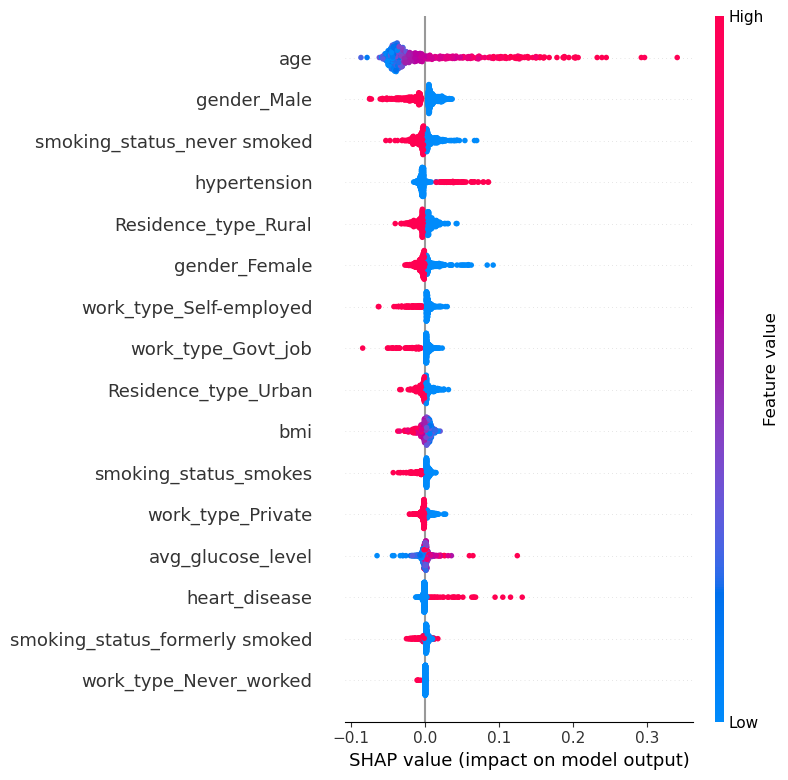

In [8]:
import shap

# Use DeepExplainer for neural network models
explainer = shap.DeepExplainer(reg_model, X_train)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)
shap_values = np.squeeze(shap_values)

shap.summary_plot(shap_values, X_test, feature_names=all_feature_names)

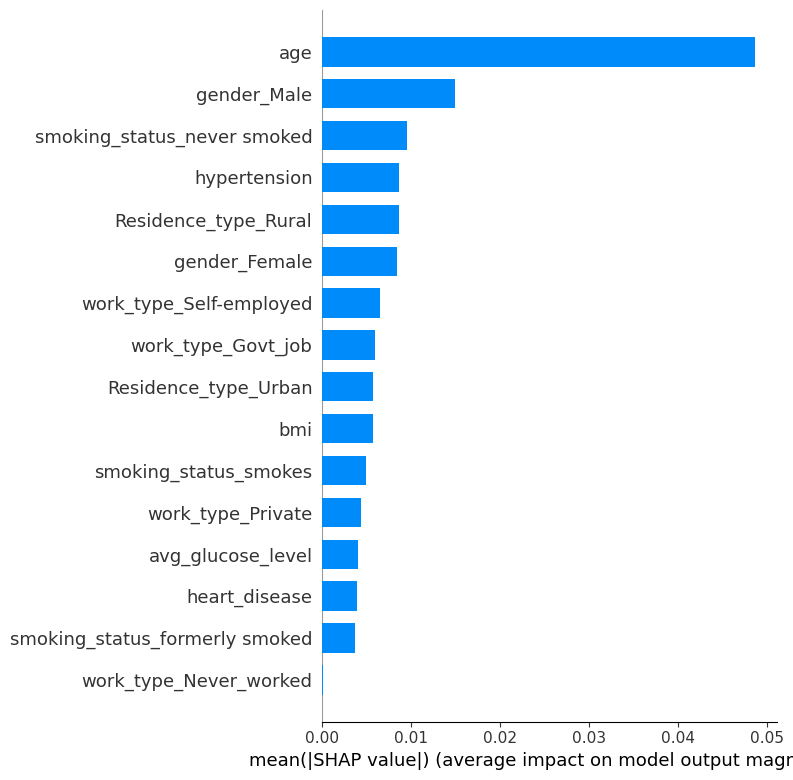

In [9]:
shap.summary_plot(shap_values, X_test, feature_names=all_feature_names, plot_type="bar")

## Shapley Lorenz

In [10]:
# Lorentz zonoid

def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

In [11]:
y_pred = reg_model.predict(X_test)

gini(y_pred)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


0.6997465432748141

In [12]:
from shapley_lz.explainer.shapley_lz import ShapleyLorenzShare as slShare

X = preprocessor.transform(X)

slz = slShare(reg_model.predict, X, y)

C:\Users\u20022\AppData\Local\anaconda3\Lib\site-packages\shapley_lz\explainer\shapley_lz.py:37: UserWarning: A background dataset larger than 50, may cause prohibitive long runtime. Consider using a sample of maximally 100 observations.
  warnings.warn('A background dataset larger than 50, may cause prohibitive long runtime. Consider using a sample of maximally 100 observations.')


Enter 's' to sample 50 observations and enter 'c', to continue with current background datasets
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from scipy.special import binom, factorial
import itertools
from tqdm import tqdm
import warnings

def patched_shapleyLorenz_val(self, X, y, n_iter=10, class_prob=True, pred_out='predict_proba', **kwargs):

    assert str(type(y)).endswith("numpy.ndarray'>"), 'response observations need to be of "numpy.ndarray" format'

    # Conditions on X
    assert X.shape[1] == self.M, 'Need to have the same number of features as in background dataset'
    assert X.shape[0] == len(y), 'Covariate matrix and response vector need to have the same number of observations'

    # Initiate variables globally
    X = standardise_data_format(X)  # standardise data
    self.N_test = X.data.shape[0]
    self.row = kwargs.get('row', None)
    
    if self.row == False:
        assert isinstance(self.row, (int, list, np.ndarray)), "not a valid row type. Needs to be either 'int', 'list', or 'array'"

    # Compute empirical mean of the dataset to be explained
    if class_prob == True and (pred_out == 'predict_proba' or pred_out == 'predict_log_proba'):
        # Check for background dataset
        val, num = np.unique(self.y_bg, return_counts=True)
        if len(val) == 1:
            raise ValueError('only observations from one class included in provided data. Need to have at least one observation from each class')
        
        # Check for dataset to be explained
        val, num = np.unique(y, return_counts=True)
        if len(val) == 1:
            raise ValueError('only observations from one class included in provided data. Need to have at least one observation from each class')

        self.y_class_mu = np.zeros((val.shape[0], 1))
        for i in range(val.shape[0]):
            self.y_class_mu[i] = num[i] / self.N_test
    elif class_prob == False or (class_prob == True and pred_out == 'predict'):
        self.y_mu = np.mean(y)

    # Container for output
    self.LZ = np.zeros((self.M, 1))  # in regression case or if 'predict' specified in classification case
    if pred_out == 'predict_proba':
        self.LZ0 = np.zeros((self.M, 1))
        self.LZ1 = np.zeros((self.M, 1))

    # Set up kernel
    self.kernel = np.zeros((2**(self.M-1), 1))
    for i, s in enumerate(self.powerset(range(self.M-1), 2**(self.M-1))):
        self.kernel[i, 0] = self.shapleyKernel(self.M, len(s))

    # Determine how many full subset sizes can be considered given "n_iter"
    num_subsets = int(np.floor((self.M-1)/2)) if np.mod((self.M-1), 2) != 0 else int((self.M-1)/2)
    num_sub_sizes = 0
    sub_sizes = 0
    self.full_subsetsizes = 0
    for m in range(num_subsets + 1):
        if sub_sizes < n_iter and m != num_subsets:
            if np.mod(self.M-1, 2) != 0 or (np.mod(self.M-1, 2) == 0 and m != (self.M-1)/2):
                swtch = 0
                sub_sizes += 2 * binom(self.M-1, m)
                num_sub_sizes += 1
            elif np.mod(self.M-1, 2) == 0 and m == (self.M-1)/2:
                swtch = 1
                sub_sizes += binom(self.M-1, m)
                num_sub_sizes += 1
        elif sub_sizes > n_iter:
            self.full_subsetsizes = (sub_sizes - 2 * binom(self.M-1, m-1)) if swtch == 0 else sub_sizes - binom(self.M-1, m-1)
            num_sub_sizes -= 2
            break
        elif sub_sizes == n_iter or (sub_sizes < n_iter and m == num_subsets):
            self.full_subsetsizes = sub_sizes

    self.full_subsetsizes = int(self.full_subsetsizes)

    # Loop over all covariates
    for k in tqdm(range(self.M)):

        # Initialise indexes
        s_all = list(range(self.M))
        s_base = s_all.copy()
        s_base.pop(k)
        k = [k, ]

        # Create dictionary of all subset sizes for which all permutations are considered
        self.full_permts = {}
        for i, s in enumerate(self.powerset(s_base, len(s_base)+1)):
            if len(s) in range(num_sub_sizes + 1) or len(s) in range(self.M-1-num_sub_sizes, self.M):
                self.full_permts[i] = s
        self.full_permts = pd.DataFrame(list(self.full_permts.items()))

        # Create dictionary of all remaining subset permutations, after considering full subset permutations, given "n_iter"
        remaining_permts = {}
        for i, s in enumerate(self.powerset(s_base, len(s_base)+1)):
            if len(s) not in range(num_sub_sizes + 1) and len(s) not in range(self.M-1-num_sub_sizes, self.M):
                remaining_permts[i] = s
        remaining_permts = pd.DataFrame(list(remaining_permts.items()))

        # Initialise variables within loop
        V_base = np.zeros((self.N, self.M, len(self.full_permts)))  # here and in the following only (M-1) permutations, because base maximally has M-1 covariates
        V_k = np.zeros((self.N, self.M, len(self.full_permts)))
        Lor_k = np.zeros((len(self.full_permts), 1))
        Lor_base = np.zeros((len(self.full_permts), 1))

        Lor_k0 = np.zeros((len(self.full_permts), 1))
        Lor_k1 = np.zeros((len(self.full_permts), 1))
        Lor_base0 = np.zeros((len(self.full_permts), 1))
        Lor_base1 = np.zeros((len(self.full_permts), 1))

        ranks = np.arange(self.N_test)

        if class_prob == False or (class_prob == True and pred_out == 'predict'):
            y_base = np.zeros((self.N_test, len(self.full_permts)))
            y_k = np.ones((self.N_test, len(self.full_permts)))
        elif class_prob == True and pred_out == 'predict_proba':
            y_base = np.zeros((self.N_test, 2, len(self.full_permts)))
            y_b0 = np.zeros((self.N_test, len(self.full_permts)))
            y_b1 = np.zeros((self.N_test, len(self.full_permts)))
            y_k = np.zeros((self.N_test, 2, len(self.full_permts)))
            y_k0 = np.zeros((self.N_test, len(self.full_permts)))
            y_k1 = np.zeros((self.N_test, len(self.full_permts)))

        # extract the corresponding kernel weight, from the full kernel weight set
        kernel = np.zeros((len(self.full_permts), 1))
        kernel_row = 0
        for i in range(len(self.kernel)):
            if i in self.full_permts.iloc[:, 0]:
                kernel[kernel_row, 0] = self.kernel[i, 0]
                kernel_row += 1

        # Loop over all possible full permutations, given "n_iter"
        i = 0
        for s in self.full_permts.iloc[:, 1]:
            # Initialise Kernel
            s = list(s)  # covariates in baseline (base model)
            s_k = k+s  # baseline covariates + kth covariate (model k)

            # Initialise background datasets for model including kth covariate and model excluding kth covariate
            V_base[:, :, i] = self.data.data
            V_k[:, :, i] = self.data.data

            # for single row
            if self.row == False:
                if type(self.row) == int:
                    if len(s) == 0:
                        V_k[:, s_k, i] = X.data[n_test, s_k]
                    else:
                        V_base[:, s, i] = X.data[n_test, s]
                        V_k[:, s_k, i] = X.data[n_test, s_k]
                    
                    if class_prob == False or (class_prob == True and pred_out == 'predict'):
                        ybase_temp = self.model.f(V_base[self.row, :, i])
                        y_base[0, i] = np.mean(ybase_temp, 0)

                        yk_temp = self.model.f(V_k[self.row, :, i])
                        y_k[0, i] = np.mean(yk_temp, 0)

                    elif class_prob == True and (pred_out == 'predict_proba' or pred_out == 'predict_log_proba'):
                        yk_temp = self.model.f(V_k[self.row, :, i]).reshape(self.N, 2)
                        y_k[0, 0, i] = np.mean(yk_temp[:, 0], 0)
                        y_k[0, 1, i] = np.mean(yk_temp[:, 1], 0)

                        ybase_temp = self.model.f(V_base[self.row, :, i]).reshape(self.N, 2)
                        y_base[0,i] = np.mean(ybase_temp,0)

                        yk_temp = self.model.f(V_k[self.row,:,i])
                        y_k[0,i] = np.mean(yk_temp,0)

                    elif class_prob == True and (pred_out == 'predict_proba' or pred_out == 'predict_log_proba'):
                        yk_temp = self.model.f(V_k[self.row,:,i]).reshape(self.N,2)
                        y_k[0, 0, i] = np.mean(yk_temp[:,0],0)
                        y_k[0, 1, i] = np.mean(yk_temp[:,1],0)

                        ybase_temp = self.model.f(V_base[self.row,:,i]).reshape(self.N,2)
                        y_base[0,0,i] = np.mean(ybase_temp[:,0],0)
                        y_base[0,1,i] = np.mean(ybase_temp[:,1],0)                            
                            
                    else:
                        raise ValueError\
                            ("Not a valid method. Valid methods are: 'predict', 'predict_proba' and 'predict_log_proba'")

                    #For specified rows
                elif isinstance(self.row, (list, np.ndarray)):
                    for n_test in range(len(self.row)):
                        if len(s) == 0:
                            V_k[:,s_k,i] = X.data[n_test,s_k]    
                        else:
                            V_base[:,s,i] = X.data[n_test, s]
                            V_k[:,s_k,i] = X.data[n_test,s_k]

                        if class_prob == False or (class_prob == True and pred_out == 'predict'):
                            ybase_temp = self.model.f(V_base[:,:,i])
                            y_base[n_test,i] = np.mean(ybase_temp,0)
                                
                            yk_temp = self.model.f(V_k[:,:,i])
                            y_k[n_test, i] = np.mean(yk_temp,0)

                        elif class_prob == True and (pred_out == 'predict_proba' or pred_out == 'predict_log_proba'):
                            yk_temp = self.model.f(V_k[:,:,i]).reshape(self.N,2)
                            y_k[n_test, 0, i] = np.mean(yk_temp[:,0],0)
                            y_k[n_test, 1, i] = np.mean(yk_temp[:,1],0)

                            ybase_temp = self.model.f(V_base[:,:,i]).reshape(self.N,2)
                            y_base[n_test,0,i] = np.mean(ybase_temp[:,0],0)
                            y_base[n_test,1,i] = np.mean(ybase_temp[:,1],0)
                        else:
                            raise ValueError\
                                ("Not a valid method. Valid methods are: 'predict', 'predict_proba' and 'predict_log_proba'")

                # No specified rows
            elif self.row in (True, None):
                for n_test in range(self.N_test):
                    if len(s) == 0:
                        V_k[:,s_k,i] = X.data[n_test,s_k]
                    else:
                        V_base[:,s,i] = X.data[n_test, s]
                        V_k[:,s_k,i] = X.data[n_test,s_k]
                        #print('\nV_base initial shape: {}'.format(V_base.shape))

                        #Compute predicted values with model w and w/o kth covariat, if no row(s) specified

                    if class_prob == False or (class_prob == True and pred_out == 'predict'):
                        ybase_temp = self.model.f(V_base[:,:,i])
                        y_base[n_test,i] = np.mean(ybase_temp,0)

                        yk_temp = self.model.f(V_k[:,:,i])
                        y_k[n_test, i] = np.mean(yk_temp,0)

                    elif class_prob == True and (pred_out == 'predict_proba' or pred_out == 'predict_log_proba'):
                        yk_temp = self.model.f(V_k[:,:,i]).reshape(self.N,2)
                        y_k[n_test, 0, i] = np.mean(yk_temp[:,0],0)
                        y_k[n_test, 1, i] = np.mean(yk_temp[:,1],0)

                        ybase_temp = self.model.f(V_base[:,:,i]).reshape(self.N,2)
                        y_base[n_test,0,i] = np.mean(ybase_temp[:,0],0)
                        y_base[n_test,1,i] = np.mean(ybase_temp[:,1],0)

                    elif pred_out not in ('predict', 'predict_proba', 'predict_log_proba'):
                        raise ValueError\
                            ('No valid method. Valid methods are: predict, predict_proba')
                
                    #Sort predicted values
                if class_prob == False or (class_prob == True and pred_out == 'predict'):
                    y_base[:,i] = np.sort(y_base[:,i],0)
                    y_k[:,i] = np.sort(y_k[:,i],0)

                elif class_prob == True and (pred_out == 'predict_proba' or pred_out == 'predict_log_proba'):    
                    y_b0[:,i] = np.sort(y_base[:,0,i],0)
                    y_b1[:,i] = np.sort(y_base[:,1,i],0)

                    y_k0[:,i] = np.sort(y_k[:,0,i],0)
                    y_k1[:,i] = np.sort(y_k[:,1,i],0)

                if class_prob == False or (class_prob == True and pred_out == 'predict'):
                    Lor_k[i,0] = (2/(self.N_test*self.y_mu))*np.cov(y_k[:,i], ranks, bias = True)[0][1]
                    Lor_base[i,0] = (2/(self.N_test*self.y_mu))*np.cov(y_base[:,i], ranks, bias = True)[0][1]


                elif class_prob == True and (pred_out == 'predict_proba' or pred_out == 'predict_log_proba'):
                    Lor_k0[i,0] = (2/(self.N_test*self.y_class_mu[0]))*np.cov(y_k0[:,i], ranks, bias = True)[0][1]
                    Lor_k1[i,0] = (2/(self.N_test*self.y_class_mu[1]))*np.cov(y_k1[:,i], ranks, bias = True)[0][1]
                    Lor_base0[i,0] = (2/(self.N_test*self.y_class_mu[0]))*np.cov(y_b0[:,i], ranks, bias = True)[0][1]
                    Lor_base1[i,0] = (2/(self.N_test*self.y_class_mu[1]))*np.cov(y_b1[:,i], ranks, bias = True)[0][1]
                    
                #Lor_val_pol = self.lz_polarisation(Lor_val_temp,self.M) # polarisation in case of negative values
                i += 1
            
        if class_prob == False or (class_prob == True and pred_out == 'predict'):
            val_bool = 0
            Lor_val = Lor_k - Lor_base
            self.LZ[k,0] = np.dot(Lor_val.T,kernel) # equation 19 on page 10 of Giudiuci and Raffinetti (Feb 2020) paper
            
        elif class_prob == True and (pred_out == 'predict_proba' or pred_out == 'predict_log_proba'):
            val_bool = 1
            Lor_val0 = Lor_k0 - Lor_base0
            Lor_val1 = Lor_k1 - Lor_base1
            self.LZ0[k,0] = np.dot(Lor_val0.T,kernel) # equation 19 on page 10 of Giudiuci and Raffinetti (Feb 2020) paper
            self.LZ1[k,0] = np.dot(Lor_val1.T,kernel) # equation 19 on page 10 of Giudiuci and Raffinetti (Feb 2020) paper
           
                    #Lor_val0_pol = self.lz_polarisation(Lor_val_temp0,self.M)
                    #Lor_val1_pol = self.lz_polarisation(Lor_val_temp1,self.M)

        # if class_prob == False or (class_prob == True and pred_out == 'predict'):
        #    self.LZ_shares = np.column_stack((X.col_names,self.LZ))
    col_names = np.array(X.col_names).reshape((self.M,1))
    if val_bool == 0:
        return np.hstack((col_names, self.LZ))
    elif val_bool == 1:
        return np.hstack((col_names, self.LZ0)), np.hstack((col_names, self.LZ1)); 

class Data:
    def __init__(self, data, col_names):
        self.data = data
        self.col_names = col_names
        n = data.shape[0]
        self.weights = np.ones(n)
        self.weights /= n
    
def standardise_data_format(value):
    if isinstance(value, Data):
        return value
    elif type(value) == np.ndarray:
        return Data(value, [str(i) for i in range(value.shape[1])])
    elif str(type(value)).endswith("pandas.core.series.Series'>"):
        return Data(value.values.reshape((1,len(value))), value.index.tolist())
    elif str(type(value)).endswith("pandas.core.frame.DataFrame'>"):
        return Data(value.values, value.columns.tolist())
    else:
        assert False, str(type(value)) + "is currently not a supported format type"  
    

    
slShare.shapleyLorenz_val = patched_shapleyLorenz_val


In [27]:
y = np.array(y)

slz_values = slz.shapleyLorenz_val(X[:20], y[:20], class_prob = True, pred_out = 'predict')

  0%|          | 0/16 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━

  6%|▋         | 1/16 [00:14<03:35, 14.35s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━

 12%|█▎        | 2/16 [00:28<03:18, 14.20s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━

 19%|█▉        | 3/16 [00:42<03:05, 14.24s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━

 25%|██▌       | 4/16 [00:56<02:48, 14.08s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━

 31%|███▏      | 5/16 [01:10<02:32, 13.88s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━

 38%|███▊      | 6/16 [01:24<02:19, 13.90s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━

 44%|████▍     | 7/16 [01:36<02:02, 13.59s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━

 50%|█████     | 8/16 [01:50<01:47, 13.45s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━

 56%|█████▋    | 9/16 [02:03<01:34, 13.43s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━

 62%|██████▎   | 10/16 [02:16<01:20, 13.42s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━

 69%|██████▉   | 11/16 [02:30<01:06, 13.38s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━

 75%|███████▌  | 12/16 [02:43<00:53, 13.26s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━

 81%|████████▏ | 13/16 [02:56<00:39, 13.21s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━

 88%|████████▊ | 14/16 [03:09<00:26, 13.17s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━

 94%|█████████▍| 15/16 [03:22<00:13, 13.29s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━

100%|██████████| 16/16 [03:36<00:00, 13.52s/it]


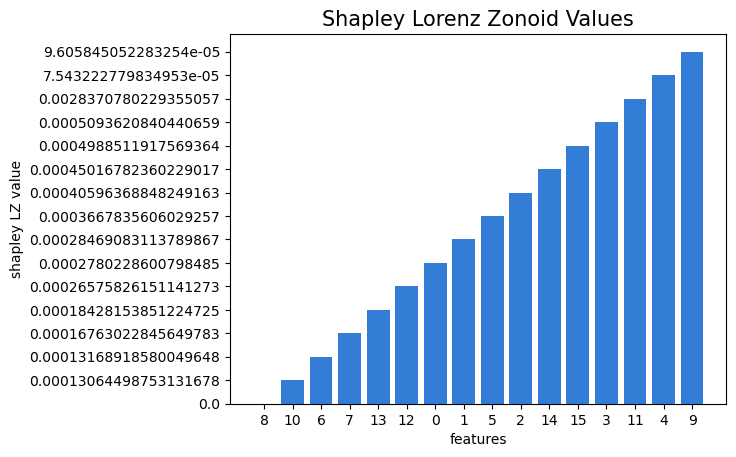

In [29]:
slz.slz_plots(slz_values)

In [42]:
features = pd.DataFrame(all_feature_names, columns=["Feature"])
features

,Feature
0,Residence_type_Rural
1,Residence_type_Urban
2,gender_Female
3,gender_Male
4,smoking_status_formerly smoked
5,smoking_status_never smoked
6,smoking_status_smokes
7,work_type_Govt_job
8,work_type_Never_worked
9,work_type_Private
